# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
import sys
!{sys.executable} -m pip install -I networkx==2.1

import pkg_resources
pkg_resources.require("networkx==2.1")

import networkx as nx

Processing /home/thdoa/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e/networkx-2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8f/b7/f329cfdc75f3d28d12c65980e4469e2fa373f1953f5df6e370e84ea2e875/decorator-4.4.1-py2.py3-none-any.whl


In [2]:
from sklearn.neighbors import KDTree
import numpy as np
import numpy.linalg as LA

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

# Generate some random 3-dimensional points
np.random.seed(0)
points = np.random.random((10, 3))  # 10 points in 3 dimensions

# Cast points into a KDTree data structure
tree = KDTree(points)

# Extract indices of 3 closest points
# Note: need to cast search point as a list 
# and return 0th element only to get back list of indices
idxs = tree.query([points[0]], k=3, return_distance=False)
# indices of 3 closest neighbors (will vary due to random sample)

print(points)
print(idxs)
nx.__version__ # should be 2.1

[[0.5488135  0.71518937 0.60276338]
 [0.54488318 0.4236548  0.64589411]
 [0.43758721 0.891773   0.96366276]
 [0.38344152 0.79172504 0.52889492]
 [0.56804456 0.92559664 0.07103606]
 [0.0871293  0.0202184  0.83261985]
 [0.77815675 0.87001215 0.97861834]
 [0.79915856 0.46147936 0.78052918]
 [0.11827443 0.63992102 0.14335329]
 [0.94466892 0.52184832 0.41466194]]
[[0 3 1]]


'2.1'

In [3]:
%matplotlib inline

# %config IPCompleter.greedy=True
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [4]:
# This is the same obstacle data from the previous lesson.
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

## Step 2 - Sample Points


You may want to limit the z-axis values.

In [5]:
from sampling import Sampler
sampler = Sampler(data, 1)

polygons = sampler.polygons
print(len(polygons))

pts = sampler.sample(300)
print(len(pts))

# Test code to undertstand kdtree, k=2
# nodes = np.array([[0, 0], [1,1], [2,2], [3, 3], [2.5, 1]])
# tree = KDTree(nodes)

# k_neighbors = tree.query([[0, 0]], 3, return_distance=False)[0]
# print(k_neighbors)

3845
190


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [13]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!


def can_connect(p1, p2):
    ls = LineString([p1, p2])
    for p in polygons:
        if p.crosses(ls) and min(p1[2], p2[2]) < p.height:
            return False
    return True

## points is list of shapely.geometry.Point(s)
# k is int param
def create_graph(points, k):
    g = nx.Graph()
    tree = KDTree(points)
    for p in points:
        neighbor_idxs = tree.query([p], k, return_distance=False)[0]
        for i in neighbor_idxs:
            if p !=  points[i] and can_connect(p, points[i]):
                g.add_edge(p, points[i], weight = LA.norm(np.array(p) - np.array(points[i])))
    return g

# Create networkx graph g using points pts 
g = create_graph(pts, 10)

## Step 4 - Visualize Graph

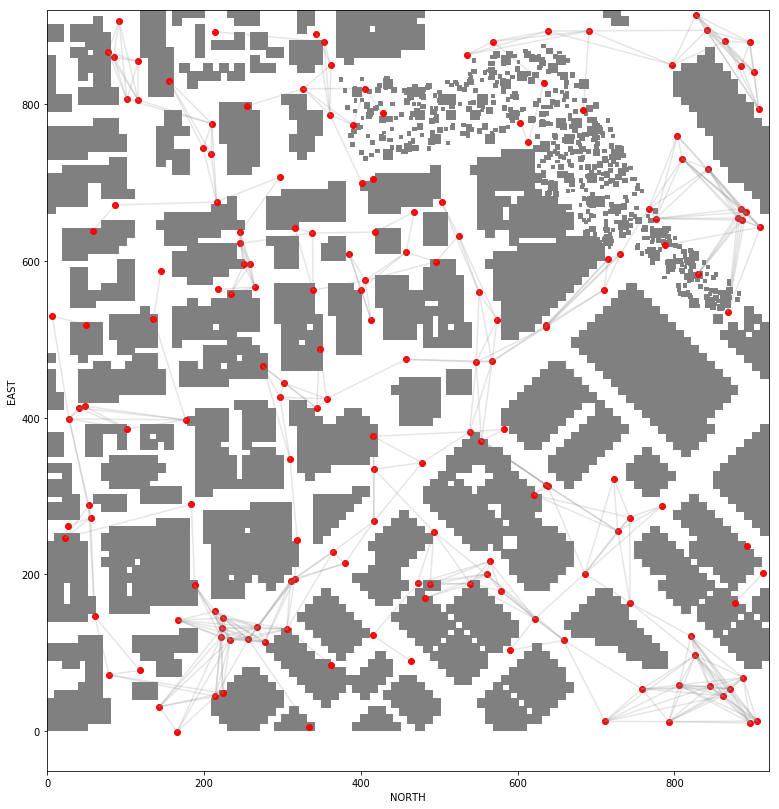

In [14]:
# Create a grid map of the world
# This will create a grid map at 1m above ground level
from grid import create_grid
grid = create_grid(data, 1, 1)
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower', alpha=0.5)

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'grey', alpha=0.2)
    
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 6 - Complete A*

In [15]:
def heuristic(n1, n2):    
    return LA.norm(np.array(n1) - np.array(n2))

def a_star(graph, heuristic, start, goal):
    path = {}
    pq = PriorityQueue()
    visited = set(start)
    pq.put((0, start))
    
    path_found = False
    while not pq.empty():
        item = pq.get()
        current_node = item[1]
        
        if current_node == start:
            current_cost = 0
        else:
            current_cost = item[0]
        
        if current_node == goal:
            print('Found a path.')
            path_found = True
            break
        else: 
            for next_node in graph[current_node]:
                if next_node not in visited:
                    visited.add(next_node)
                    n_gcost = current_cost + graph[current_node][next_node]['weight']
                    n_estcost = n_gcost + heuristic(current_node, next_node)
                    
                    pq.put((n_estcost, next_node))
                    path[next_node]=(n_gcost, current_node)
    
    print('path_found = ', path_found)
    if not path_found:
        print('Path not found.')
        return (None, None)
    
    paths = []
    n = goal
    while n != start:
        paths.append(n)
        n = path[n][1]        
    paths.append(start)
    return (paths, path[goal])

In [23]:
st_idx = np.random.randint(1, g.number_of_nodes()/2)
end_idx = np.random.randint(g.number_of_nodes()/2, g.number_of_nodes())
start_node = list(g.nodes)[st_idx]
goal_node =  list(g.nodes)[end_idx]
path, path_cost = a_star(g, heuristic, start_node, goal_node)

Found a path.
path_found =  True


## Step 7 - Visualize Path

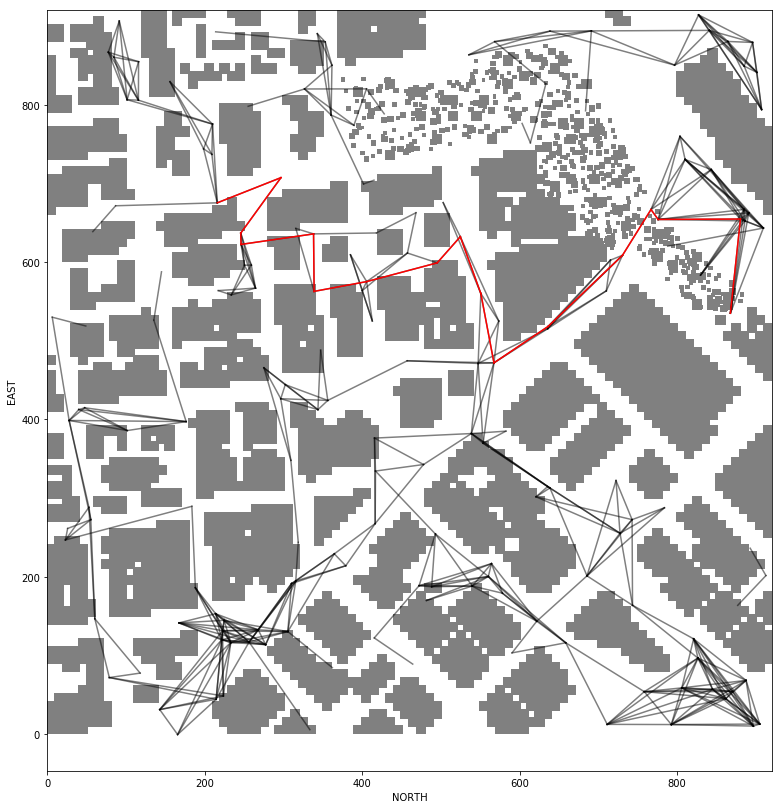

In [24]:
fig = plt.figure()
plt.imshow(grid, cmap='Greys', origin='lower', alpha=0.5)

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

for i in range(len(path)-1):
    n1 = path[i]
    n2 = path[i+1]
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'red' , alpha=1)
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()